# Model V3 : Transfer Learning : Mobile Net

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms import transforms
import matplotlib.pyplot as plt

## Load Data

### Download dataset

In [2]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Directly convert to 3 channels
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])

In [3]:
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=False,
    transform=transform
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=False,
    transform=transform
)


print(f"Train dataset:{len(train_data)}")
print(f"Test dataset:{len(test_data)}")

Train dataset:60000
Test dataset:10000


In [4]:
classes = train_data.classes
class_to_idx = train_data.class_to_idx

classes, class_to_idx

(['0 - zero',
  '1 - one',
  '2 - two',
  '3 - three',
  '4 - four',
  '5 - five',
  '6 - six',
  '7 - seven',
  '8 - eight',
  '9 - nine'],
 {'0 - zero': 0,
  '1 - one': 1,
  '2 - two': 2,
  '3 - three': 3,
  '4 - four': 4,
  '5 - five': 5,
  '6 - six': 6,
  '7 - seven': 7,
  '8 - eight': 8,
  '9 - nine': 9})

### Make dataloaders

In [5]:
from torch.utils.data import DataLoader
import os

BATCH_SIZE = 128
NUM_WORKERS = os.cpu_count()

train_data_loader = DataLoader(
    dataset=train_data,
    shuffle=True,
    num_workers=NUM_WORKERS,
    batch_size=BATCH_SIZE
)

test_data_loader = DataLoader(
    dataset=test_data,
    shuffle=False,
    num_workers=NUM_WORKERS,
    batch_size=BATCH_SIZE
)

print(f" Train Dataloader Length: {len(train_data_loader)}")
print(f" Test Dataloader Length: {len(test_data_loader)}")

 Train Dataloader Length: 469
 Test Dataloader Length: 79


### Check Sample

In [6]:
image, label = train_data[0]
image.shape, type(image), label

(torch.Size([3, 28, 28]), torch.Tensor, 5)

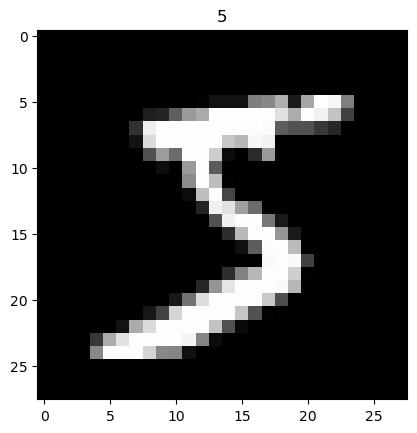

In [10]:
import matplotlib.pyplot as plt
from PIL import Image
img_display = image.permute(1, 2, 0) 
plt.imshow(img_display.squeeze(), cmap="gray")
plt.title(label)
plt.show()

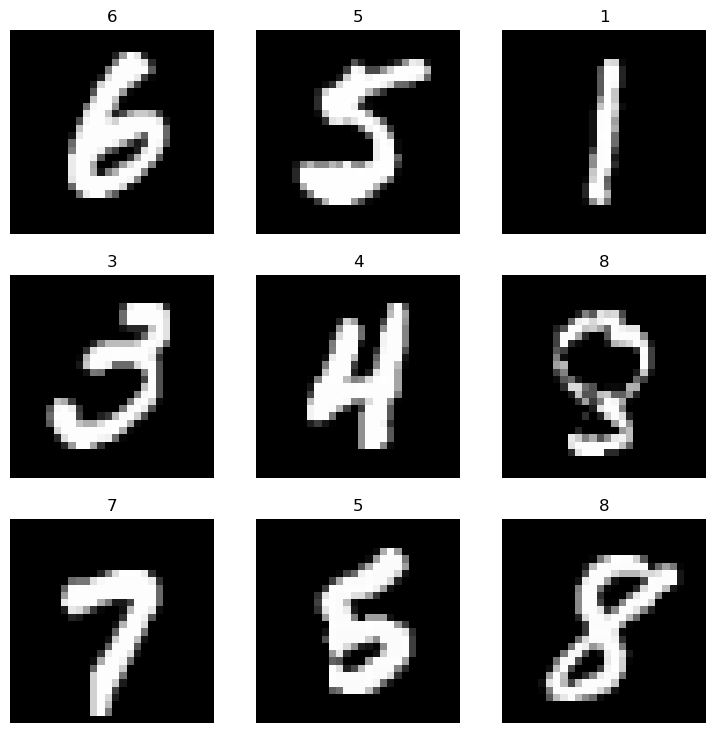

In [11]:
figure = plt.figure(figsize=(9, 9))
nrows, ncols = 3, 3

for i in range(1, ncols * nrows + 1):
    random_id = torch.randint(len(train_data), size=(1, )).item()
    image, label = train_data[random_id]
    img_display = image.permute(1, 2, 0) 
    figure.add_subplot(nrows, ncols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img_display.squeeze(), cmap="gray")
plt.show()

## Train Model

### Setup Device agnostic code

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### Model

In [13]:
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights)
model

C:\Users\Jaycp\miniconda3\envs\adm\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [14]:
num_ftrs = model.classifier[3].in_features  # 1024
model.classifier[3] = nn.Linear(num_ftrs, len(classes))


model

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

### Optimizer and Loss Function & Accuracy

In [15]:
LEARNING_RATE = 0.001

def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_pred, y_true).sum().item()
    return correct

loss_fn = torch.nn.CrossEntropyLoss()
optimizer =  torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

### Train Pass

In [16]:
%%time
from tqdm import tqdm
import chime

EPOCHS = 10
torch.manual_seed(42)
history_train, history_test = {'loss':[], 'accuracy':[]}, {'loss':[], 'accuracy':[]}

for epoch in range(EPOCHS):
    print(f"EPOCH : {epoch+1}/{EPOCHS}----------------------------------------------------")
    
    train_loss, train_acc = 0, 0
    test_loss, test_acc = 0, 0
    model.train()
    for batch, (X, y) in enumerate(tqdm(train_data_loader)):
         #--------------training-------------------------
        
        # put data on device  : GPU/CPU
        X_train, y_train = X.to(device), y.to(device)
        batch_size = X_train.size(0)
    
        # make prediction (get logits)
        y_logits = model(X_train).squeeze()
        
        # calculate loss
        loss = loss_fn(y_logits, y_train)
        train_loss += loss.item() * batch_size
    
        # turn logits into predictions for accuracy calculation
        y_pred = torch.argmax(y_logits, dim=1)
        accuracy = accuracy_fn(y_pred, y_train)
        train_acc += accuracy 
    
        # set all gradient to zero
        optimizer.zero_grad()
    
        # backpropagation
        loss.backward()
    
        # optimizer step: update the weights
        optimizer.step()

        #--------------testing-------------------------
    model.eval()
    with torch.no_grad():     # torch.inference_mode(): gives error if i have to use accuracy inside it
        for (X, y) in tqdm(test_data_loader):
    
            # do the prediction
            X_test, y_test = X.to(device), y.to(device)
            batch_size = X_test.size(0)
    
            # forward pass
            y_test_pred = model(X_test).squeeze()
            preds = torch.argmax(y_test_pred, dim=1)
    
            # loss & Accuracy
            loss= loss_fn(y_test_pred, y_test)
            test_loss += loss.item() * batch_size
    
            accuracy = accuracy_fn(preds, y_test)
            test_acc += accuracy 
    
    train_acc = (train_acc / len(train_data_loader.dataset)) * 100
    train_loss /= len(train_data_loader.dataset)
    test_acc = (test_acc / len(test_data_loader.dataset)) * 100
    test_loss /= len(test_data_loader.dataset)

    
    history_train["loss"].append(train_loss)
    history_train["accuracy"].append(train_acc)
    history_test["loss"].append(test_loss)
    history_test["accuracy"].append(test_acc)
    chime.success()
    
    print(f"    Train Loss: {train_loss:.4f}--|--Train Accuracy: {train_acc:.4f}--|--Test Loss: {test_loss:.4f}----|----Test Accuracy: {test_acc:.4f}")

EPOCH : 1/10----------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:42<00:00,  1.84it/s]


    Train Loss: 0.2937--|--Train Accuracy: 90.5983--|--Test Loss: 0.1550----|----Test Accuracy: 95.1800
EPOCH : 2/10----------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:43<00:00,  1.80it/s]


    Train Loss: 0.0854--|--Train Accuracy: 97.3133--|--Test Loss: 0.0633----|----Test Accuracy: 98.0700
EPOCH : 3/10----------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:42<00:00,  1.84it/s]


    Train Loss: 0.0636--|--Train Accuracy: 97.9850--|--Test Loss: 0.0656----|----Test Accuracy: 97.8700
EPOCH : 4/10----------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:40<00:00,  1.96it/s]


    Train Loss: 0.0516--|--Train Accuracy: 98.3217--|--Test Loss: 0.0593----|----Test Accuracy: 98.2800
EPOCH : 5/10----------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:43<00:00,  1.82it/s]


    Train Loss: 0.0448--|--Train Accuracy: 98.5133--|--Test Loss: 0.0477----|----Test Accuracy: 98.4500
EPOCH : 6/10----------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:40<00:00,  1.95it/s]


    Train Loss: 0.0424--|--Train Accuracy: 98.6567--|--Test Loss: 0.0924----|----Test Accuracy: 97.5100
EPOCH : 7/10----------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:43<00:00,  1.82it/s]


    Train Loss: 0.0397--|--Train Accuracy: 98.7283--|--Test Loss: 0.0511----|----Test Accuracy: 98.5100
EPOCH : 8/10----------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:43<00:00,  1.83it/s]


    Train Loss: 0.0364--|--Train Accuracy: 98.8267--|--Test Loss: 0.0624----|----Test Accuracy: 98.4400
EPOCH : 9/10----------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:42<00:00,  1.84it/s]


    Train Loss: 0.0440--|--Train Accuracy: 98.7050--|--Test Loss: 0.8995----|----Test Accuracy: 81.5000
EPOCH : 10/10----------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:43<00:00,  1.83it/s]

    Train Loss: 0.0480--|--Train Accuracy: 98.4733--|--Test Loss: 0.0608----|----Test Accuracy: 98.3100
CPU times: total: 4h 32min 53s
Wall time: 1h 32min 22s


In [17]:
checkpoint = {
    'epoch': EPOCHS,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss_fn,
    
    # Hyperparameters
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'optimizer_name': 'Adam',
    'loss_fn_name': 'CrossEntropyLoss',
    
    # Model architecture info
    'model_class': 'MNISTmodelv0',
    'model_architecture': str(model),  
    
    #  history
    'history_train': history_train,
    'history_test': history_test,
}

torch.save(checkpoint, f'checkpoint_modelv4.pth')

## Evaluation

### Loss Accuracy Plot

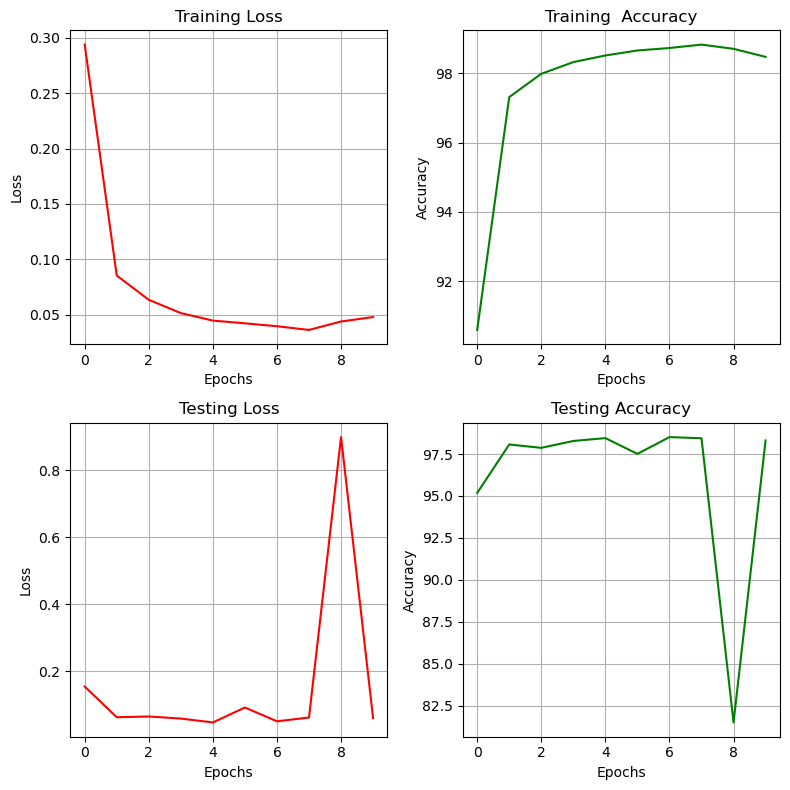

In [18]:
import matplotlib.pyplot as plt

hist_train, hist_test = checkpoint['history_train'], checkpoint['history_test']
epochs = checkpoint['epoch'] | EPOCHS

hist_train["loss"], type(hist_train["loss"])

fig, axs = plt.subplots(2, 2, figsize=(8, 8))

axs[0, 0].plot(range(epochs), hist_train["loss"], label="Loss", color="red")
axs[0, 0].set_title("Training Loss")
axs[0, 0].set_xlabel("Epochs")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].grid(True)

axs[0, 1].plot(range(epochs), hist_train["accuracy"], label="Accuracy", color="green")
axs[0, 1].set_title("Training  Accuracy")
axs[0, 1].set_xlabel("Epochs")
axs[0, 1].set_ylabel("Accuracy")
axs[0, 1].grid(True)

axs[1, 0].plot(range(epochs), hist_test["loss"], label="Loss",  color="red")
axs[1, 0].set_title("Testing Loss")
axs[1, 0].set_xlabel("Epochs")
axs[1, 0].set_ylabel("Loss")
axs[1, 0].grid(True)

axs[1, 1].plot(range(epochs), hist_test["accuracy"], label="Accuracy",  color="green")
axs[1, 1].set_title("Testing Accuracy")
axs[1, 1].set_xlabel("Epochs")
axs[1, 1].set_ylabel("Accuracy")
axs[1, 1].grid(True)


fig.tight_layout()
plt.show()

### Confusion Metrics

C:\Users\Jaycp\AppData\Local\Temp\ipykernel_7348\3172542366.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoint_modelv4.pth')
C:\Users\J

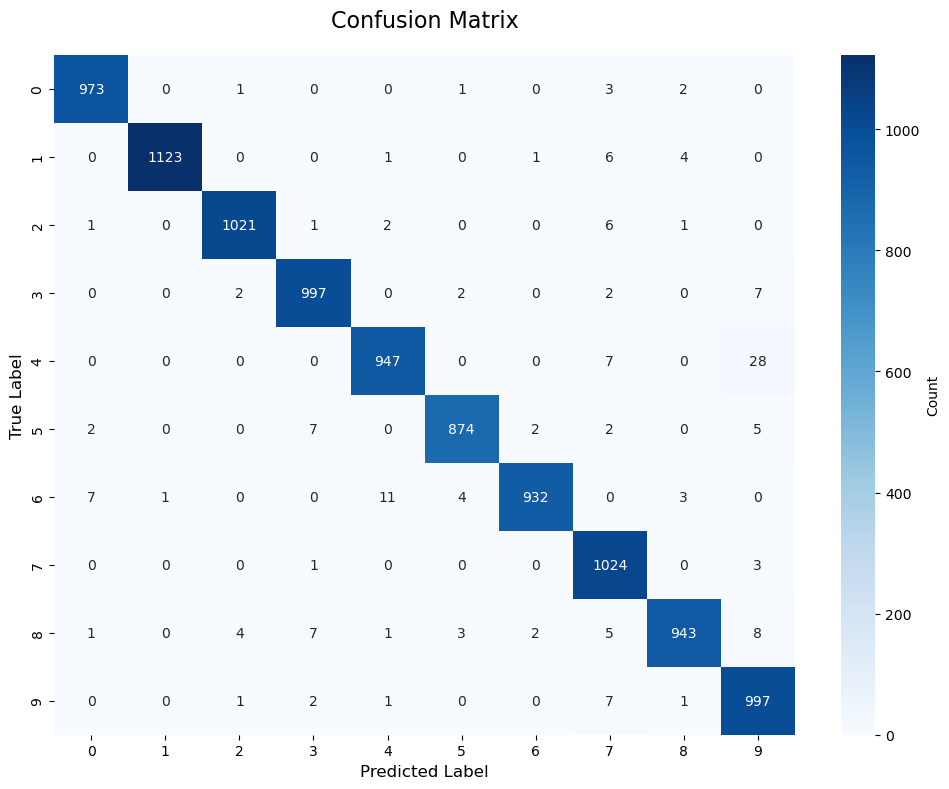


Classification Report:
              precision    recall  f1-score   support

           0     0.9888    0.9929    0.9908       980
           1     0.9991    0.9894    0.9942      1135
           2     0.9922    0.9893    0.9908      1032
           3     0.9823    0.9871    0.9847      1010
           4     0.9834    0.9644    0.9738       982
           5     0.9887    0.9798    0.9842       892
           6     0.9947    0.9729    0.9836       958
           7     0.9642    0.9961    0.9799      1028
           8     0.9885    0.9682    0.9782       974
           9     0.9513    0.9881    0.9694      1009

    accuracy                         0.9831     10000
   macro avg     0.9833    0.9828    0.9830     10000
weighted avg     0.9833    0.9831    0.9831     10000


Per-Class Accuracy:
Class 0: 99.29%
Class 1: 98.94%
Class 2: 98.93%
Class 3: 98.71%
Class 4: 96.44%
Class 5: 97.98%
Class 6: 97.29%
Class 7: 99.61%
Class 8: 96.82%
Class 9: 98.81%


In [20]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def plot_confusion_matrix(model, test_loader, device, class_names=None):
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            
            outputs = model(X)
            preds = torch.argmax(outputs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    cm = confusion_matrix(all_labels, all_preds)
    
    if class_names is None:
        class_names = [str(i) for i in range(cm.shape[0])]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    
    plt.title('Confusion Matrix', fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

    
    print("\nClassification Report:")
    print("=" * 60)
    print(classification_report(all_labels, all_preds, 
                                target_names=class_names,
                                digits=4))
    
    # Print per-class accuracy
    print("\nPer-Class Accuracy:")
    print("=" * 60)
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    for i, acc in enumerate(class_accuracy):
        print(f"Class {class_names[i]}: {acc*100:.2f}%")
    
    return cm, all_preds, all_labels


checkpoint = torch.load('checkpoint_modelv4.pth')
model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights)
num_ftrs = model.classifier[3].in_features  # 1024
model.classifier[3] = nn.Linear(num_ftrs, len(classes))
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)

class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
cm, predictions, labels = plot_confusion_matrix(model, test_data_loader, device, class_names)

### Check Predictions

In [23]:
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

def predict_image(image_path, model, device, class_names=None):

    transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])
    
    # Load and transform image
    image = Image.open(image_path)
    image_tensor = transform(image)
    
    # Add batch dimension: (1, 28, 28) -> (1, 1, 28, 28)
    image_tensor = image_tensor.unsqueeze(0).to(device)
    
    # Make prediction
    model.eval()
    with torch.inference_mode():
        logits = model(image_tensor)
        probabilities = torch.softmax(logits, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0, predicted_class].item()
    
    # Get class name
    if class_names:
        predicted_label = class_names[predicted_class]
    else:
        predicted_label = str(predicted_class)
    
    # Display results
    
    print(f"Original LabelPredicted Class: {predicted_label}")
    print(f"Confidence: {confidence * 100:.2f}%")
    print(f"\nAll probabilities:")
    for i, prob in enumerate(probabilities[0]):
        label = class_names[i] if class_names else str(i)
        print(f"  Class {label}: {prob.item() * 100:.2f}%")
    
    return predicted_class, confidence, probabilities[0]


# Usage:
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
pred_class, conf, probs = predict_image('testing/three_03.jpeg', 
                                         model, 
                                         device, 
                                         class_names)

Original LabelPredicted Class: 3
Confidence: 100.00%

All probabilities:
  Class 0: 0.00%
  Class 1: 0.00%
  Class 2: 0.00%
  Class 3: 100.00%
  Class 4: 0.00%
  Class 5: 0.00%
  Class 6: 0.00%
  Class 7: 0.00%
  Class 8: 0.00%
  Class 9: 0.00%
